# Introduction

Bayesian computation requires computational efforts to derive the posterior distribution $p(\theta \mid y)$, and the posterior predictive distribution $p(\tilde{y}\mid y)$. Both these quantities usually don't have the closed-form solutions, which mean they are intractable. As a result, we need some algorithms to approximate these integrals while still maintain the convergence and accuracy of the object. To begin with, we will lay our hand on first method that could approximately evaluate the numerical integration, namely *Importance Sampling*. Let's start with the problem defined 

## Problem Statement

Suppose we have **$\theta$** as our concerned parameter (which is also a random variable). Moreover, **$\theta$** follows a distribution **$p(\theta)$**. Our wish is to estimate the expectation of any function **$f(\theta)$**, which is $E_{p}(f(\theta))$. Based on Monte Carlo method, we could obtain random samples of **$\theta$** from the distribution $p$ and approximate the quantity as follows:

\begin{align}
E_{p}(f(\theta)) & = \int_{-\infty}^{\infty} f(\theta) p(\theta \mid y) \, d\theta \\
& \approx \frac{1}{N} \sum_{i = 1}^{N} f(\theta_{i}).
\end{align}

## Importance Sampling

This is a method that is connected to rejection sampling and a forerunner of classic Metropolis algorithm. By inspecting the formula above, one problem arises is that if **$p(\theta\mid y)$** is difficult to
 sample, then one could not draw $N$ random samples of $\theta_{i}$ and the integrals could not be defined by simply averaging the simulated values.
Assumed that there exists an arbitray density **$q(\theta)$** (also called the *instrumental* or *proposal* distribution) that we could easily samples from. Then we could alternatively represented the expectation as follows:
\begin{align}
E_{p}(f(\theta)) & = \int_{-\infty}^{\infty} f(\theta) p(\theta \mid y) \, d\theta \\
& = \int_{-\infty}^{\infty} f(\theta)\frac{q(\theta \mid y)}{q(\theta \mid y)} p(\theta \mid y) \, d\theta \\
& = E_{q}\left[f(\theta) \frac{p(\theta \mid y)}{q(\theta \mid y)}\right]
\end{align}
**Note:** The last equation is the expectation under $q$ - our proposal distribution not under $p$ - the distribution of concern. Hence, you could imagine that we just perform a change in probability measure. From this expectation, the estimation is identical to the above by sampling values $\left\{\theta_{i} \right\}_{i = 1}^{N}$ from q and computing 
\begin{align}
E_{q}\left[f(\theta) \frac{p(\theta \mid y)}{q(\theta \mid y)}\right] = \frac{1}{N} \sum_{j = 1}^{N} f(\theta_{j}) \frac{p(\theta_{j})}{q(\theta_{j})}
\end{align}
This importance sampling also justifies the convergence to the target quantity under the condition that supremum of $q$ must below the supremum of $(f \times p)$. That is, as long as $\text{sup}(f \times p) \subset \text{sup}(q)$. Under this property, the convergence is guagranteed.

\begin{align}
\frac{1}{N} \sum_{j = 1}^{N} f(\theta_{j}) \frac{p(\theta_{j})}{q(\theta_{j})} \longrightarrow E_{p}(f(\theta))
\end{align}

*Imporance ratios* or *importance weights* are the terms $\frac{p(\theta_{i})}{q(\theta_{i})}$. The reason for the favor of this method is that there is little restriction on the choice of the proposal distribution. You can choose either easy to simulate distribution or one that is efficient in approximating the integral. Now, let's conduct some experiment to gain some insights about this sampling method.

## **Example (Beta distribution)**

In this example, we will examine the approximation of importance sampling with Beta distribution. The p.d.f of Beta is 
\begin{align}
p(x, \alpha, \beta) = \frac{x^{(\alpha - 1)} (1-x)^{(\beta - 1)}} {\mathbb{B}(\alpha, \beta)}
\end{align}
where $\mathbb{B} (\alpha, \beta) = \frac{\mathbb{\Gamma(\alpha)}\mathbb{\Gamma(\beta)}}{\Gamma(\alpha + \beta)}$ and $\mathbb{\Gamma}$ is a Gamma function - for $n$ being a positive integer, $\Gamma(n) = (n-1)!$

In [ ]:
import numpy as np 
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

We will create a function to generate samples for beta distribution using Importance Sampling method. This function will take on 5 essential arguments:
- `f` is the target function 
- `p` is the target distribution 
- `q` is the proposal distribution
- `q_sample` is number of samples from $q$
- `N` is number of samples to draw for our interest parameters. 
Moreover, if `return_hist = True`, then we will only return the estimated expectation (the final value) using the above method, otherwise we will derive full path of estimated values.

In [ ]:
def importance_sampling(f, p, q, q_sample, N, return_hist = False, verbose = True):
  N_samples = int(N) # Make sure to get integer
  x = q_sample(N)
  size = len(x)
  if verbose:
    print("-----------------------------------------------------------------")
    print("{} Importance Sampling Simulations of Size {}".format(N, 
                                                                 size))
    print("-----------------------------------------------------------------")
  
  # Create samples of interest 
  f = f(x) * p(x) / q(x)
  hist = np.cumsum(f) / np.arange(1, N+1, 1)
  if return_hist:
    return hist[-1], hist
  else:
    return hist[-1]

In [ ]:
def beta_dist(x, alpha, beta):
  return scipy.stats.beta.pdf(x , alpha, beta)

def beta_exp(alpha, beta):
  return alpha / (alpha + beta)

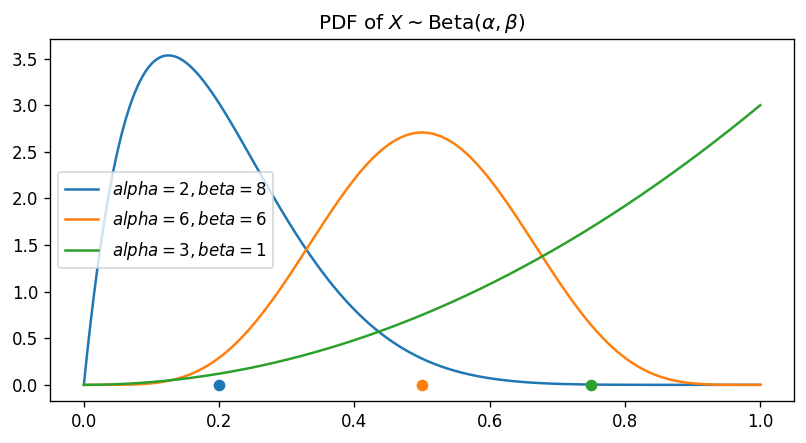

In [ ]:
As = [2, 6, 3]
Bs = [8, 6, 1]

fig = plt.figure(figsize=(8, 4), dpi=120)
x = np.linspace(start=0, stop=1, num=1000)
for A, B in zip(As, Bs):
    f = beta_dist(x, A, B)
    p = plt.plot(x, f, label= f'$alpha = {A}, beta = {B}$')

    e = beta_exp(A, B)
    plt.plot(e, 0, 'o', color=p[0].get_color())
plt.title(r'PDF of $X \sim$Beta$(\alpha, \beta)$')
plt.legend()
plt.show()

In [ ]:
def uniform_dist(x, a = 0, b= 1.0):
  return 1.0 * (a <= x) * (x <= b)

# The same as numpy random uniform sampling function
def uniform_sample(N, a = 0.0, b = 1.0):
  return np.random.rand(N) * (b - a) + a

In [ ]:
def sampling_beta(alpha = As, beta = Bs, N_samples = 500000):
  # As = [2, 6, 3]
  # Bs = [8, 6, 1]
  u = []
  h = []
  r = []
  for (a,b) in zip(alpha, beta):
    f = lambda x: x
    p_pdf = lambda x: beta_dist(x, a, b)
    q_pdf = uniform_dist
    q_sample = uniform_sample
    temp, temp_hist = importance_sampling(f, p_pdf, q_pdf, q_sample, N = N_samples, 
                                verbose = False, return_hist = True)
    # Append estimated mean 
    u.append(temp)
    h.append(temp_hist)
    # Append true mean
    r.append(beta_exp(a, b))
    
    
  result = pd.DataFrame(zip(u, r), columns = ["Estimated","True"])
  return result, h

def plotting(df, history, N = 500000):
  step = 100
  x = range(0, N, step)
  h = history
  r = df['True']
  # Define elements for plot
  fig, axs = plt.subplots(3,1 ,figsize = (20,10))
  fig.subplots_adjust(hspace = .5)
  fig.suptitle("Convergence of Importance sampling in three examples")
  
  for i in range(df.shape[0]):
    axs[i].plot(x , h[i][x], label = "Estimated Value")
    axs[i].set_ylim(r[i] - 0.002, r[i] + 0.002)
    axs[i].axhline(r[i], color = "r", label = "True value")
  
  plt.show()

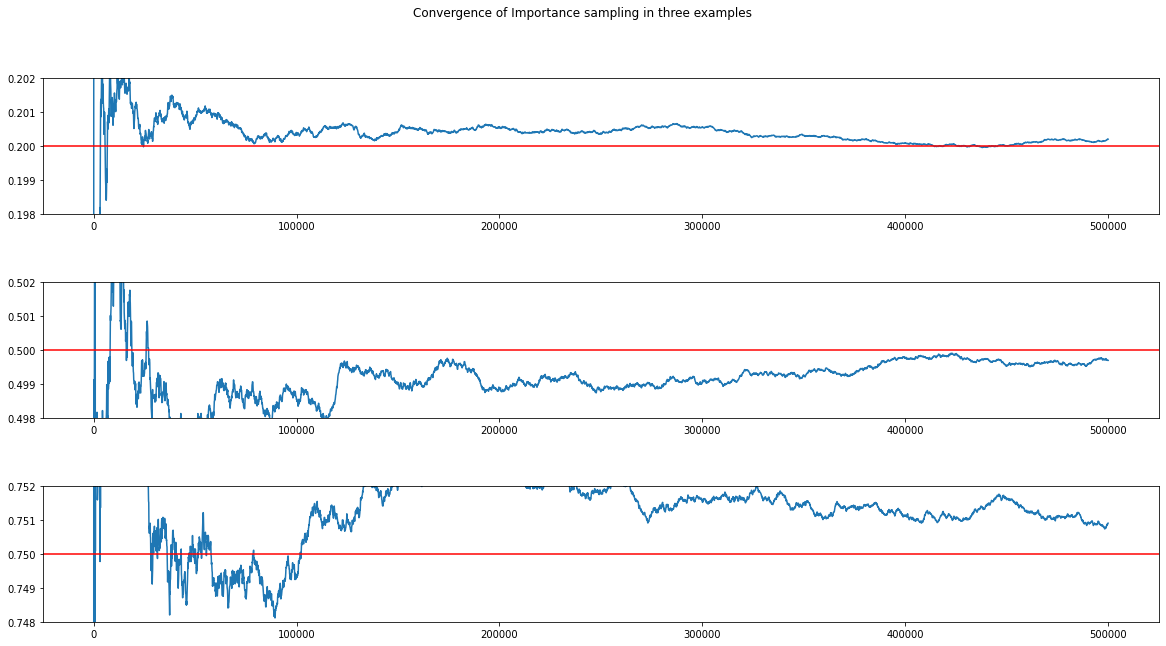

In [ ]:
result_df, hist = sampling_beta()
print(result_df)
plotting(result_df, hist)

TO BE CONTINUE ...